In [8]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data_sim as mdmask

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Ingest methods

In [10]:
def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))
        
def get_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type,
                             base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel:
        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource

## Visualization methods

In [11]:
def get_img_grid(img, cmap='Greys'):
    numSlices = 3
    size = img.GetSize()
    ret = []
    for i in range(img.GetDimension()):
        start = size[2 - i] / (numSlices + 1)
        sliceList = np.linspace(start, size[2 - i] - start, numSlices)
        sliceSize = list(size)
        sliceSize[2 - i] = 0

        for (j, slice) in enumerate(sliceList):
            sliceIndex = [0] * img.GetDimension()
            sliceIndex[2 - i] = int(slice)
            sliceImg = sitk.Extract(img, sliceSize, sliceIndex)
            sliceArray = sitk.GetArrayFromImage(sliceImg)
            ret.append(sliceArray)
    return ret

In [12]:
def register_lddmm(affine_img, 
                   target_img, 
                   alpha_list=0.05, 
                   scale_list=[0.0625, 0.125, 0.25, 0.5, 1.0], 
                   epsilon_list=1e-4, 
                   min_epsilon_list=1e-10, 
                   sigma=0.1, 
                   use_mi=False, 
                   iterations=200, 
                   inMask=None, 
                   refMask=None, 
                   verbose=True, 
                   out_dir=''):
    if sigma == None:
        sigma = (0.1/target_img.GetNumberOfPixels())

    (field, invField) = ndreg.imgMetamorphosisComposite(affine_img, target_img,
                                                        alphaList=alpha_list,
                                                        scaleList=scale_list,
                                                        epsilonList=epsilon_list,
                                                        minEpsilonList=min_epsilon_list,
                                                        sigma=sigma,
                                                        useMI=use_mi,
                                                        inMask=inMask,
                                                        refMask=refMask,
                                                        iterations=iterations,
                                                        verbose=verbose,
                                                        outDirPath=out_dir)

    source_lddmm = ndreg.imgApplyField(affine_img, field,
                                            size=target_img.GetSize(),
                                            spacing=target_img.GetSpacing())
    return source_lddmm, field, invField

# Quantify error

In [13]:
def compute_boundary(img):
    array = sitk.GetArrayFromImage(preprocessor.create_mask(img, use_triangle=True))
    height, depth, width = array.shape
    boundary = np.zeros((height, depth, width))
    for k in range(depth):
        for i in range(width):
            for j in reversed(range(height)):
                if hemi_mask[j,k,i] > 0:
                    boundary[j,k,i] = 1
                    break
    return boundary

def quantify_boundary_error(img, boundary, img_slice=50):
    array = sitk.GetArrayFromImage(preprocessor.create_mask(img, use_triangle=True))
    height, depth, width = array.shape
    
    height_vals = []
    MSE = 0
    N = 0
    for j in range(width):
        loc = np.where(array[:,img_slice,j])[0]
        if loc.size == 1:
            MSE += (loc[0] - boundary)**2
            N += 1
    MSE /= N
    return MSE

# Setup Data

In [14]:
resolution = 50

In [15]:
rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
atlas = ndreg.download_ara(rmt, resolution)
width, height, depth = atlas.GetSize()

In [16]:
atlas_mask = preprocessor.create_mask(atlas, use_triangle=True)

In [17]:
annotations = ndreg.download_ara(rmt, resolution, type='annotation')

## Create the Missing data masks

In [19]:
# 2/5 mask
two_fifth_array = mdmask.gen_frac_mask(depth, height, width, 0.4)
two_fifth_mask = mdmask.convert_to_image(two_fifth_array.astype('uint16'))
# 1/2 mask
half_array = mdmask.gen_hemisphere_mask(depth, height, width)
half_mask = mdmask.convert_to_image(half_array.astype('uint16'))
# 3/5 mask
three_fifth_array = mdmask.gen_frac_mask(depth, height, width, 0.6)
three_fifth_mask = mdmask.convert_to_image(three_fifth_array.astype('uint16'))

# Copy img information over
two_fifth_mask.CopyInformation(atlas)
half_mask.CopyInformation(atlas)
three_fifth_mask.CopyInformation(atlas)

# Create the missing data atlases

In [20]:
# 2/5 atlas
two_fifth_atlas = mdmask.mask_img(atlas, two_fifth_mask)

# 1/2 atlas
half_atlas = mdmask.mask_img(atlas, half_mask)

# 3/5 atlas
three_fifth_atlas = mdmask.mask_img(atlas, three_fifth_mask)

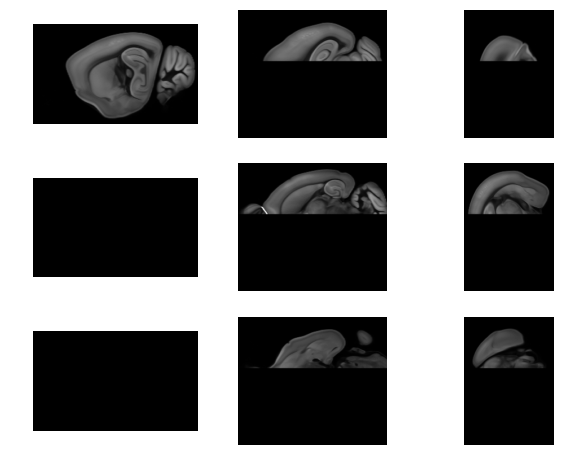

In [21]:
ndreg.imgShow(two_fifth_atlas)

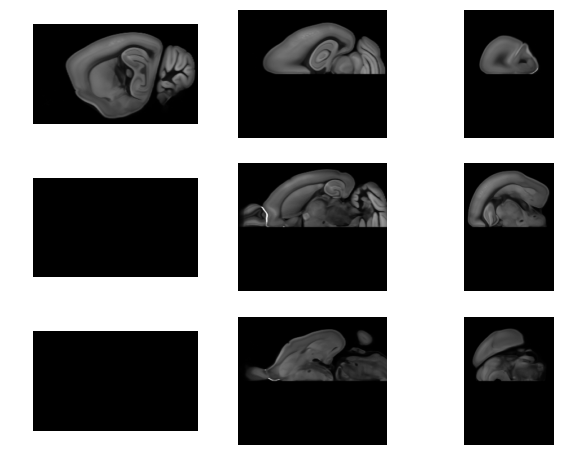

In [22]:
ndreg.imgShow(half_atlas)

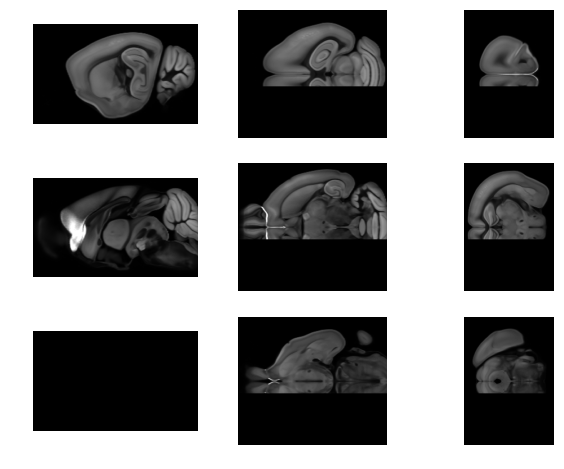

In [23]:
ndreg.imgShow(three_fifth_atlas)

# Visualize the brains

In [ ]:
two_fifth_grid = get_img_grid(two_fifth_atlas)
half_grid = get_img_grid(half_atlas)
three_fifth_grid = get_img_grid(three_fifth_atlas)

In [ ]:
grids = [two_fifth_grid, half_grid, three_fifth_grid]
grid_titles = ['2/5', '1/2', '3/5']
row_len = len(grids[0])
col_len = len(grids)

In [ ]:
import matplotlib.gridspec as gridspec
plt.clf()
fig = plt.figure(figsize=(40,20))
gs1 = gridspec.GridSpec(
    nrows=row_len, 
    ncols=col_len, 
    left=0.1,
    right=0.25,
)
for i,grid in enumerate(grids):
    for k in range(row_len):
        ax = plt.subplot(gs1[(i+1)+(col_len*k)-1])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(grid[k])
        if not k:
            ax.set_title(grid_titles[i])
# plt.show()
plt.savefig("masked_atlases.png")

# Registration

In [24]:
print(half_atlas.GetSpacing())

(0.05, 0.05, 0.05)


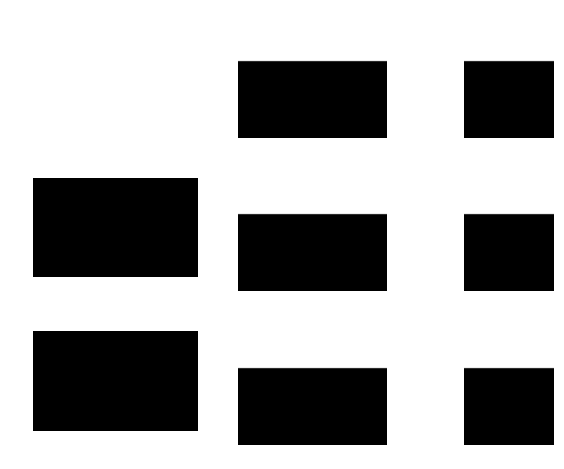

In [36]:
ndreg.imgShow(two_fifth_mask)

On atlas: 2/5
On mask: 2/5


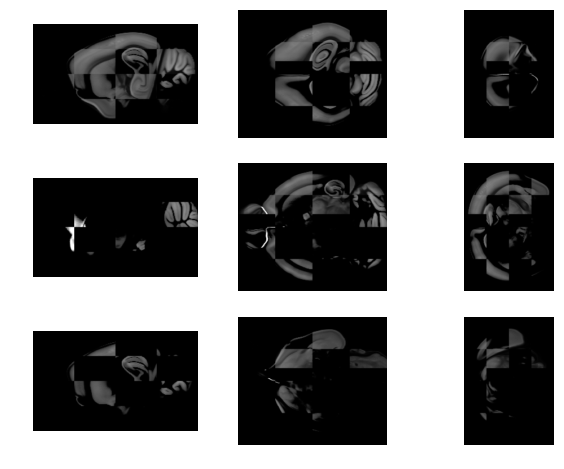

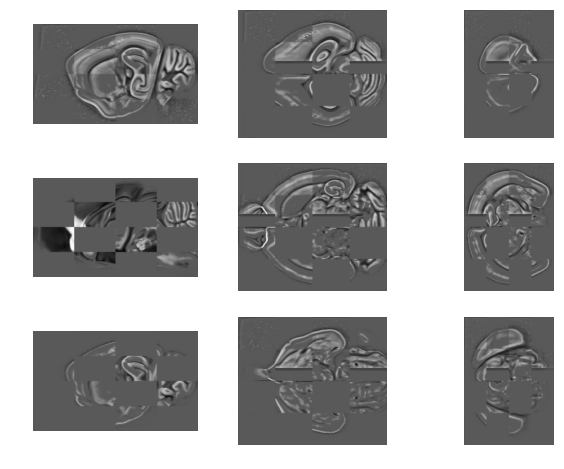


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	48248.2, 2.92846, 0, 48245.2 (89.9014%), 5.500000e-04
1.	47477.3, 4.36074, 0, 47472.9 (88.4622%), 3.025000e-04
2.	45751.7, 5.25336, 0, 45746.5 (85.2451%), 1.663750e-04
3.	44770.7, 6.49743, 0, 44764.2 (83.4148%), 1.830125e-04
4.	44311.7, 8.13507, 0, 44303.6 (82.5564%), 2.013138e-04
5.	43519.4, 10.0661, 0, 43509.3 (81.0764%), 2.214451e-04
6.	43158.3, 12.4662, 0, 43145.8 (80.3989%), 2.435896e-04
7.	42411.9, 15.2936, 0, 42396.6 (79.0029%), 2.679486e-04
8.	42057.9, 16.9292, 0, 42040.9 (78.3401%), 1.473717e-04
9.	41564.1, 18.7965, 0, 41545.3 (77.4166%), 1.621089e-04
10.	41261.7, 20.968, 0, 41240.8 (76.849%), 1.783198e-04
11.	40821.9, 23.4585, 0, 40798.4 (76.0248%), 1.961518e-04
12.	40471.2, 26.3394, 0, 40444.9 (75.3659%), 2.157670e-04
13.	39998.6, 29.6557, 0, 39969 (74.4791%), 2.373436e-04
14.	39681.8, 33.4979, 0, 39648.3 (73.8815%), 2.610780e-04
15.	39114.2, 37.9277, 0, 39076.3 (72.8157


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	49601.4, 0.111045, 0, 49601.3 (98.5174%), 1.100000e-03
1.	49579.7, 0.269044, 0, 49579.5 (98.474%), 6.050000e-04
2.	49388.3, 0.401298, 0, 49387.9 (98.0935%), 3.327500e-04
3.	49271.6, 0.416287, 0, 49271.1 (97.8616%), 1.830125e-04
4.	48829.3, 0.488586, 0, 48828.8 (96.9829%), 2.013138e-04
5.	48700.7, 0.525463, 0, 48700.1 (96.7275%), 1.107226e-04
6.	48644.9, 0.574359, 0, 48644.4 (96.6167%), 1.217948e-04
7.	48581.7, 0.630516, 0, 48581 (96.4909%), 1.339743e-04
8.	48514.7, 0.695111, 0, 48514 (96.3578%), 1.473717e-04
9.	48443.4, 0.76955, 0, 48442.7 (96.2161%), 1.621089e-04
10.	48368.1, 0.855489, 0, 48367.2 (96.0662%), 1.783198e-04
11.	48288.7, 0.954876, 0, 48287.8 (95.9084%), 1.961518e-04
12.	48205.6, 1.07001, 0, 48204.5 (95.743%), 2.157670e-04
13.	48119, 1.20361, 0, 48117.8 (95.5708%), 2.373436e-04
14.	48029.5, 1.35887, 0, 48028.1 (95.3927%), 2.610780e-04
15.	47937.7, 1.53959, 0, 47936.1 (95.

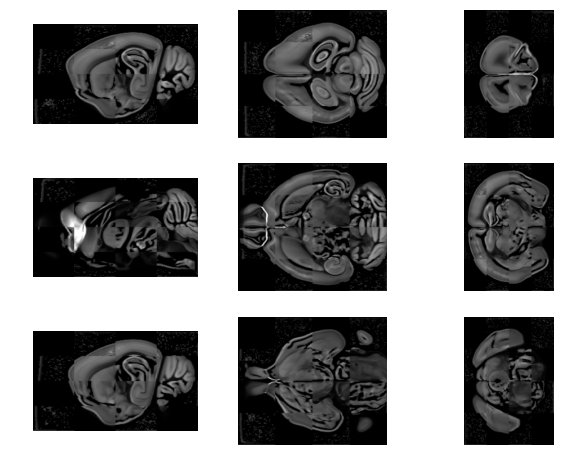

On mask: 1/2


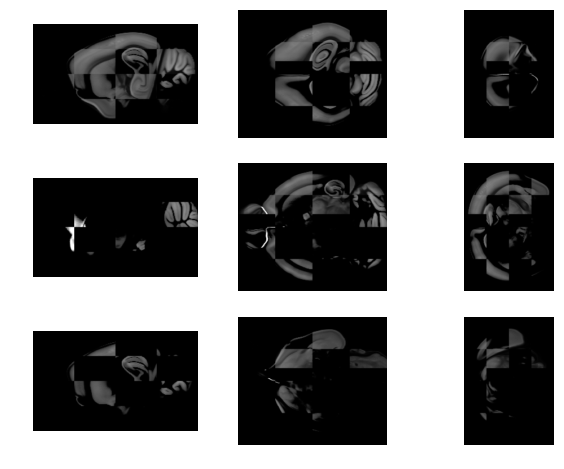

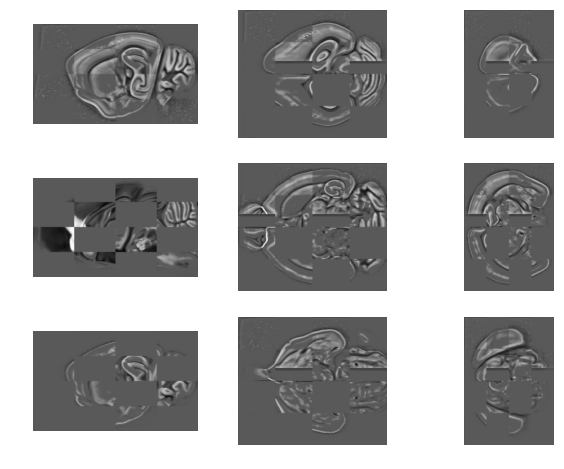


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	48248.2, 2.92846, 0, 48245.2 (89.9014%), 5.500000e-04
1.	47477.3, 4.36074, 0, 47472.9 (88.4622%), 3.025000e-04
2.	45751.7, 5.25336, 0, 45746.5 (85.2451%), 1.663750e-04
3.	44770.7, 6.49743, 0, 44764.2 (83.4148%), 1.830125e-04
4.	44311.7, 8.13507, 0, 44303.6 (82.5564%), 2.013138e-04
5.	43519.4, 10.0661, 0, 43509.3 (81.0764%), 2.214451e-04
6.	43158.3, 12.4662, 0, 43145.8 (80.3989%), 2.435896e-04
7.	42411.9, 15.2936, 0, 42396.6 (79.0029%), 2.679486e-04
8.	42057.9, 16.9292, 0, 42040.9 (78.3401%), 1.473717e-04
9.	41564.1, 18.7965, 0, 41545.3 (77.4166%), 1.621089e-04
10.	41261.7, 20.968, 0, 41240.8 (76.849%), 1.783198e-04
11.	40821.9, 23.4585, 0, 40798.4 (76.0248%), 1.961518e-04
12.	40471.2, 26.3394, 0, 40444.9 (75.3659%), 2.157670e-04
13.	39998.6, 29.6557, 0, 39969 (74.4791%), 2.373436e-04
14.	39681.8, 33.4979, 0, 39648.3 (73.8815%), 2.610780e-04
15.	39114.2, 37.9277, 0, 39076.3 (72.8157


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	49601.4, 0.111045, 0, 49601.3 (98.5174%), 1.100000e-03
1.	49579.7, 0.269044, 0, 49579.5 (98.474%), 6.050000e-04
2.	49388.3, 0.401298, 0, 49387.9 (98.0935%), 3.327500e-04
3.	49271.6, 0.416287, 0, 49271.1 (97.8616%), 1.830125e-04
4.	48829.3, 0.488586, 0, 48828.8 (96.9829%), 2.013138e-04
5.	48700.7, 0.525463, 0, 48700.1 (96.7275%), 1.107226e-04
6.	48644.9, 0.574359, 0, 48644.4 (96.6167%), 1.217948e-04
7.	48581.7, 0.630516, 0, 48581 (96.4909%), 1.339743e-04
8.	48514.7, 0.695111, 0, 48514 (96.3578%), 1.473717e-04
9.	48443.4, 0.76955, 0, 48442.7 (96.2161%), 1.621089e-04
10.	48368.1, 0.855489, 0, 48367.2 (96.0662%), 1.783198e-04
11.	48288.7, 0.954876, 0, 48287.8 (95.9084%), 1.961518e-04
12.	48205.6, 1.07001, 0, 48204.5 (95.743%), 2.157670e-04
13.	48119, 1.20361, 0, 48117.8 (95.5708%), 2.373436e-04
14.	48029.5, 1.35887, 0, 48028.1 (95.3927%), 2.610780e-04
15.	47937.7, 1.53959, 0, 47936.1 (95.

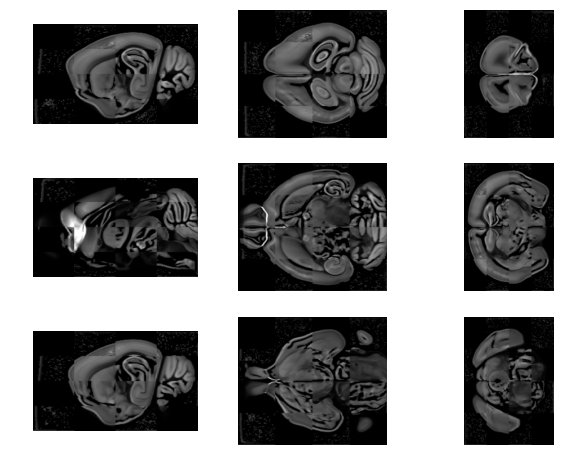

On mask: 3/5


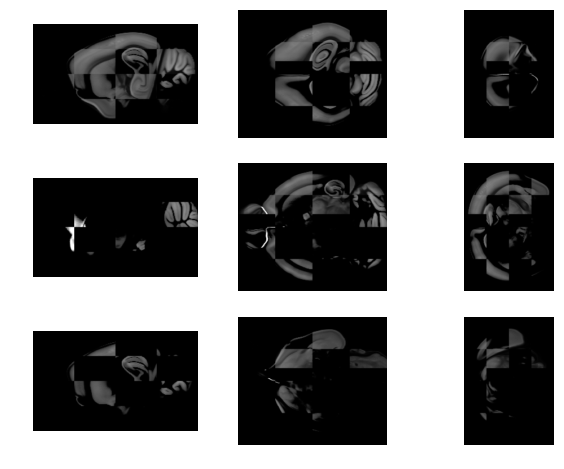

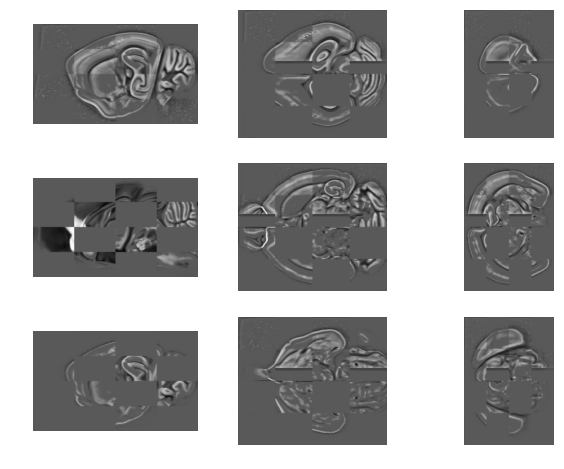


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	48248.2, 2.92846, 0, 48245.2 (89.9014%), 5.500000e-04
1.	47477.3, 4.36074, 0, 47472.9 (88.4622%), 3.025000e-04
2.	45751.7, 5.25336, 0, 45746.5 (85.2451%), 1.663750e-04
3.	44770.7, 6.49743, 0, 44764.2 (83.4148%), 1.830125e-04
4.	44311.7, 8.13507, 0, 44303.6 (82.5564%), 2.013138e-04
5.	43519.4, 10.0661, 0, 43509.3 (81.0764%), 2.214451e-04
6.	43158.3, 12.4662, 0, 43145.8 (80.3989%), 2.435896e-04
7.	42411.9, 15.2936, 0, 42396.6 (79.0029%), 2.679486e-04
8.	42057.9, 16.9292, 0, 42040.9 (78.3401%), 1.473717e-04
9.	41564.1, 18.7965, 0, 41545.3 (77.4166%), 1.621089e-04
10.	41261.7, 20.968, 0, 41240.8 (76.849%), 1.783198e-04
11.	40821.9, 23.4585, 0, 40798.4 (76.0248%), 1.961518e-04
12.	40471.2, 26.3394, 0, 40444.9 (75.3659%), 2.157670e-04
13.	39998.6, 29.6557, 0, 39969 (74.4791%), 2.373436e-04
14.	39681.8, 33.4979, 0, 39648.3 (73.8815%), 2.610780e-04
15.	39114.2, 37.9277, 0, 39076.3 (72.8157


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	49601.4, 0.111045, 0, 49601.3 (98.5174%), 1.100000e-03
1.	49579.7, 0.269044, 0, 49579.5 (98.474%), 6.050000e-04
2.	49388.3, 0.401298, 0, 49387.9 (98.0935%), 3.327500e-04
3.	49271.6, 0.416287, 0, 49271.1 (97.8616%), 1.830125e-04
4.	48829.3, 0.488586, 0, 48828.8 (96.9829%), 2.013138e-04
5.	48700.7, 0.525463, 0, 48700.1 (96.7275%), 1.107226e-04
6.	48644.9, 0.574359, 0, 48644.4 (96.6167%), 1.217948e-04
7.	48581.7, 0.630516, 0, 48581 (96.4909%), 1.339743e-04
8.	48514.7, 0.695111, 0, 48514 (96.3578%), 1.473717e-04
9.	48443.4, 0.76955, 0, 48442.7 (96.2161%), 1.621089e-04
10.	48368.1, 0.855489, 0, 48367.2 (96.0662%), 1.783198e-04
11.	48288.7, 0.954876, 0, 48287.8 (95.9084%), 1.961518e-04
12.	48205.6, 1.07001, 0, 48204.5 (95.743%), 2.157670e-04
13.	48119, 1.20361, 0, 48117.8 (95.5708%), 2.373436e-04
14.	48029.5, 1.35887, 0, 48028.1 (95.3927%), 2.610780e-04
15.	47937.7, 1.53959, 0, 47936.1 (95.

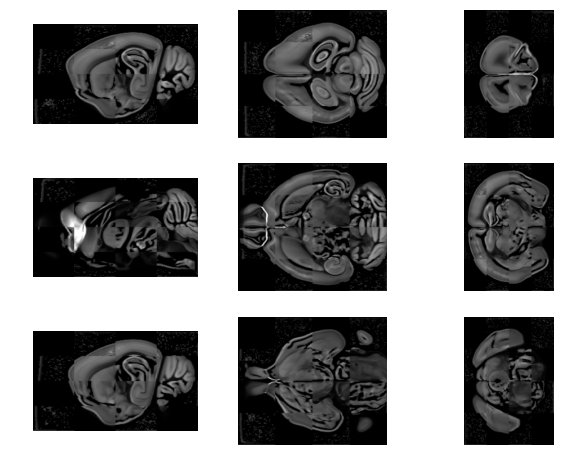

On atlas: 1/2
On mask: 2/5


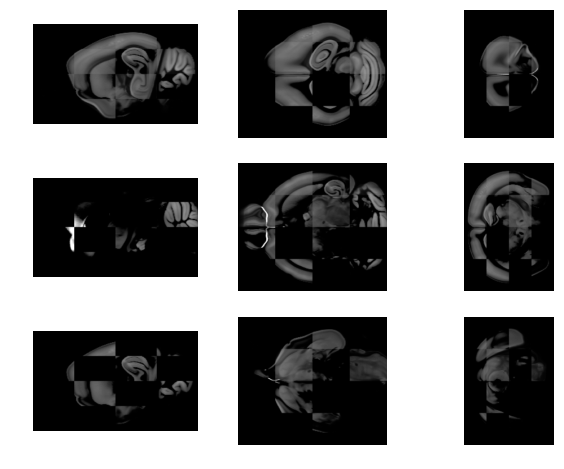

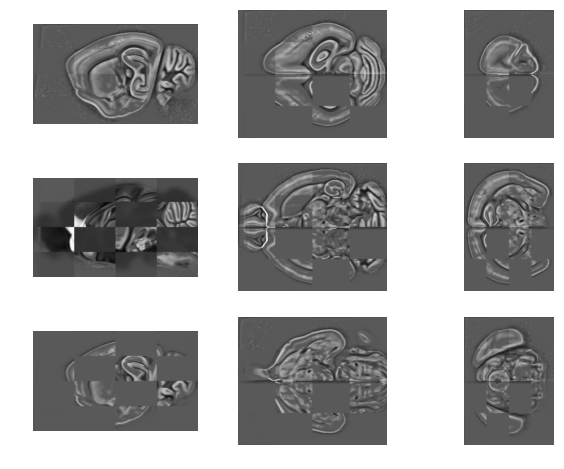


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	40217.5, 9.67969, 0, 40207.8 (93.0084%), 1.100000e-03
1.	35998.9, 10.0031, 0, 35988.9 (83.2493%), 3.025000e-04
2.	35380.2, 10.9253, 0, 35369.3 (81.8161%), 1.663750e-04
3.	34767.7, 12.2005, 0, 34755.5 (80.3962%), 1.830125e-04
4.	34410.4, 13.7949, 0, 34396.6 (79.5661%), 2.013138e-04
5.	33956.7, 15.7569, 0, 33940.9 (78.5119%), 2.214451e-04
6.	33624.1, 18.117, 0, 33605.9 (77.737%), 2.435896e-04
7.	33168.8, 20.9364, 0, 33147.9 (76.6774%), 2.679486e-04
8.	32914.4, 24.2713, 0, 32890.1 (76.0812%), 2.947435e-04
9.	32432.2, 28.212, 0, 32404 (74.9568%), 3.242178e-04
10.	32301.2, 30.4529, 0, 32270.8 (74.6485%), 1.783198e-04
11.	31991.5, 33.0047, 0, 31958.5 (73.9262%), 1.961518e-04
12.	31826, 35.9196, 0, 31790.1 (73.5366%), 2.157670e-04
13.	31537.5, 39.2331, 0, 31498.2 (72.8615%), 2.373436e-04
14.	31368.2, 43.0271, 0, 31325.1 (72.4611%), 2.610780e-04
15.	31069.4, 47.341, 0, 31022.1 (71.76%), 2.


Step 3: alpha=0.05, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	35442, 0.0433749, 0, 35441.9 (99.3599%), 2.750000e-04
1.	35310.9, 0.024926, 0, 35310.9 (98.9926%), 1.512500e-04
2.	35176.7, 0.0520591, 0, 35176.7 (98.6162%), 1.663750e-04
3.	35064.2, 0.0688592, 0, 35064.1 (98.3007%), 1.830125e-04
4.	34963.8, 0.108155, 0, 34963.7 (98.0192%), 2.013138e-04
5.	34853.5, 0.142459, 0, 34853.3 (97.7098%), 2.214451e-04
6.	34780.2, 0.206978, 0, 34779.9 (97.5041%), 2.435896e-04
7.	34663.9, 0.2281, 0, 34663.7 (97.1782%), 1.339743e-04
8.	34610.6, 0.268042, 0, 34610.4 (97.0286%), 1.473717e-04
9.	34539.3, 0.310348, 0, 34539 (96.8286%), 1.621089e-04
10.	34477.7, 0.363055, 0, 34477.4 (96.6558%), 1.783198e-04
11.	34404.5, 0.422963, 0, 34404.1 (96.4503%), 1.961518e-04
12.	34337.7, 0.495621, 0, 34337.2 (96.2628%), 2.157670e-04
13.	34259.6, 0.578817, 0, 34259 (96.0437%), 2.373436e-04
14.	34193.5, 0.680323, 0, 34192.9 (95.8582%), 2.610780e-04
15.	34113.8, 0.794476, 0, 3411

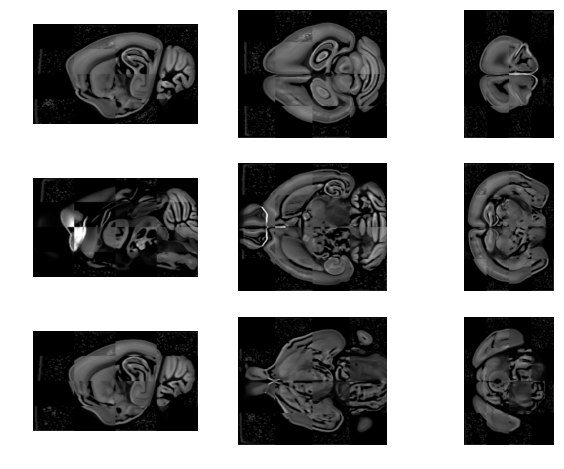

On mask: 1/2


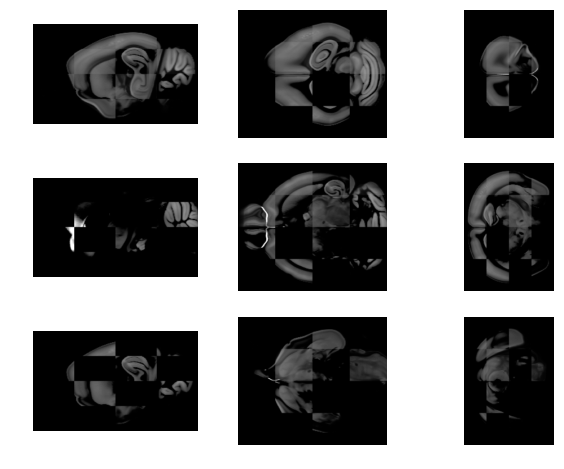

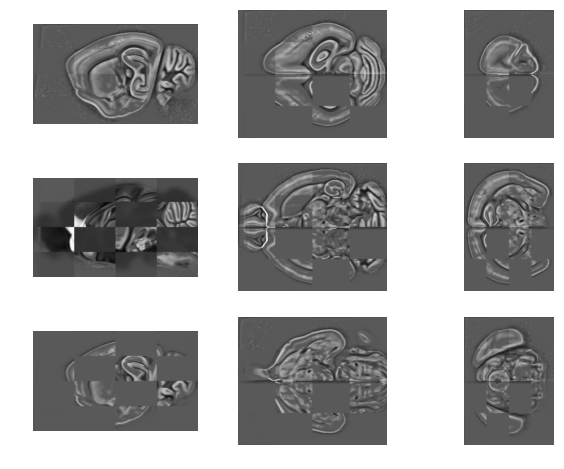


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	40217.5, 9.67969, 0, 40207.8 (93.0084%), 1.100000e-03
1.	35998.9, 10.0031, 0, 35988.9 (83.2493%), 3.025000e-04
2.	35380.2, 10.9253, 0, 35369.3 (81.8161%), 1.663750e-04
3.	34767.7, 12.2005, 0, 34755.5 (80.3962%), 1.830125e-04
4.	34410.4, 13.7949, 0, 34396.6 (79.5661%), 2.013138e-04
5.	33956.7, 15.7569, 0, 33940.9 (78.5119%), 2.214451e-04
6.	33624.1, 18.117, 0, 33605.9 (77.737%), 2.435896e-04
7.	33168.8, 20.9364, 0, 33147.9 (76.6774%), 2.679486e-04
8.	32914.4, 24.2713, 0, 32890.1 (76.0812%), 2.947435e-04
9.	32432.2, 28.212, 0, 32404 (74.9568%), 3.242178e-04
10.	32301.2, 30.4529, 0, 32270.8 (74.6485%), 1.783198e-04
11.	31991.5, 33.0047, 0, 31958.5 (73.9262%), 1.961518e-04
12.	31826, 35.9196, 0, 31790.1 (73.5366%), 2.157670e-04
13.	31537.5, 39.2331, 0, 31498.2 (72.8615%), 2.373436e-04
14.	31368.2, 43.0271, 0, 31325.1 (72.4611%), 2.610780e-04
15.	31069.4, 47.341, 0, 31022.1 (71.76%), 2.


Step 3: alpha=0.05, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	35442, 0.0433749, 0, 35441.9 (99.3599%), 2.750000e-04
1.	35310.9, 0.024926, 0, 35310.9 (98.9926%), 1.512500e-04
2.	35176.7, 0.0520591, 0, 35176.7 (98.6162%), 1.663750e-04
3.	35064.2, 0.0688592, 0, 35064.1 (98.3007%), 1.830125e-04
4.	34963.8, 0.108155, 0, 34963.7 (98.0192%), 2.013138e-04
5.	34853.5, 0.142459, 0, 34853.3 (97.7098%), 2.214451e-04
6.	34780.2, 0.206978, 0, 34779.9 (97.5041%), 2.435896e-04
7.	34663.9, 0.2281, 0, 34663.7 (97.1782%), 1.339743e-04
8.	34610.6, 0.268042, 0, 34610.4 (97.0286%), 1.473717e-04
9.	34539.3, 0.310348, 0, 34539 (96.8286%), 1.621089e-04
10.	34477.7, 0.363055, 0, 34477.4 (96.6558%), 1.783198e-04
11.	34404.5, 0.422963, 0, 34404.1 (96.4503%), 1.961518e-04
12.	34337.7, 0.495621, 0, 34337.2 (96.2628%), 2.157670e-04
13.	34259.6, 0.578817, 0, 34259 (96.0437%), 2.373436e-04
14.	34193.5, 0.680323, 0, 34192.9 (95.8582%), 2.610780e-04
15.	34113.8, 0.794476, 0, 3411

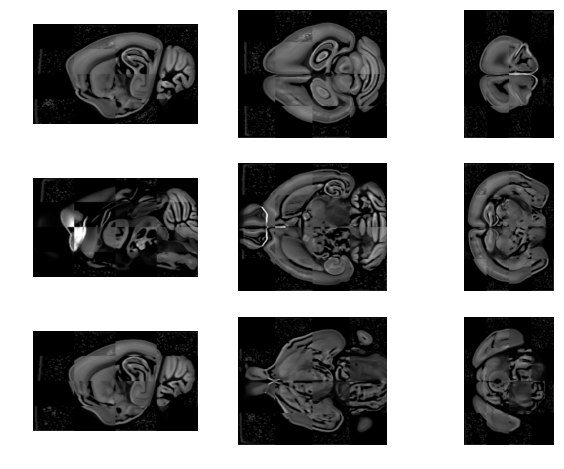

On mask: 3/5


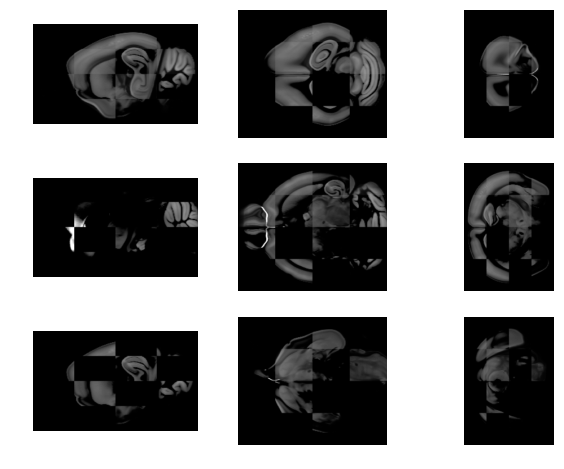

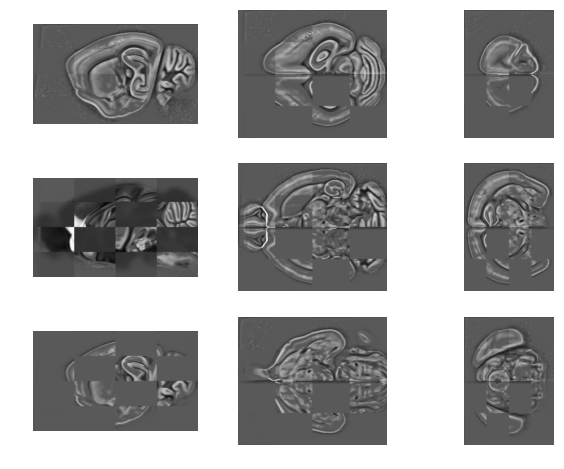


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	40217.5, 9.67969, 0, 40207.8 (93.0084%), 1.100000e-03
1.	35998.9, 10.0031, 0, 35988.9 (83.2493%), 3.025000e-04
2.	35380.2, 10.9253, 0, 35369.3 (81.8161%), 1.663750e-04
3.	34767.7, 12.2005, 0, 34755.5 (80.3962%), 1.830125e-04
4.	34410.4, 13.7949, 0, 34396.6 (79.5661%), 2.013138e-04
5.	33956.7, 15.7569, 0, 33940.9 (78.5119%), 2.214451e-04
6.	33624.1, 18.117, 0, 33605.9 (77.737%), 2.435896e-04
7.	33168.8, 20.9364, 0, 33147.9 (76.6774%), 2.679486e-04
8.	32914.4, 24.2713, 0, 32890.1 (76.0812%), 2.947435e-04
9.	32432.2, 28.212, 0, 32404 (74.9568%), 3.242178e-04
10.	32301.2, 30.4529, 0, 32270.8 (74.6485%), 1.783198e-04
11.	31991.5, 33.0047, 0, 31958.5 (73.9262%), 1.961518e-04
12.	31826, 35.9196, 0, 31790.1 (73.5366%), 2.157670e-04
13.	31537.5, 39.2331, 0, 31498.2 (72.8615%), 2.373436e-04
14.	31368.2, 43.0271, 0, 31325.1 (72.4611%), 2.610780e-04
15.	31069.4, 47.341, 0, 31022.1 (71.76%), 2.


Step 3: alpha=0.05, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	35442, 0.0433749, 0, 35441.9 (99.3599%), 2.750000e-04
1.	35310.9, 0.024926, 0, 35310.9 (98.9926%), 1.512500e-04
2.	35176.7, 0.0520591, 0, 35176.7 (98.6162%), 1.663750e-04
3.	35064.2, 0.0688592, 0, 35064.1 (98.3007%), 1.830125e-04
4.	34963.8, 0.108155, 0, 34963.7 (98.0192%), 2.013138e-04
5.	34853.5, 0.142459, 0, 34853.3 (97.7098%), 2.214451e-04
6.	34780.2, 0.206978, 0, 34779.9 (97.5041%), 2.435896e-04
7.	34663.9, 0.2281, 0, 34663.7 (97.1782%), 1.339743e-04
8.	34610.6, 0.268042, 0, 34610.4 (97.0286%), 1.473717e-04
9.	34539.3, 0.310348, 0, 34539 (96.8286%), 1.621089e-04
10.	34477.7, 0.363055, 0, 34477.4 (96.6558%), 1.783198e-04
11.	34404.5, 0.422963, 0, 34404.1 (96.4503%), 1.961518e-04
12.	34337.7, 0.495621, 0, 34337.2 (96.2628%), 2.157670e-04
13.	34259.6, 0.578817, 0, 34259 (96.0437%), 2.373436e-04
14.	34193.5, 0.680323, 0, 34192.9 (95.8582%), 2.610780e-04
15.	34113.8, 0.794476, 0, 3411

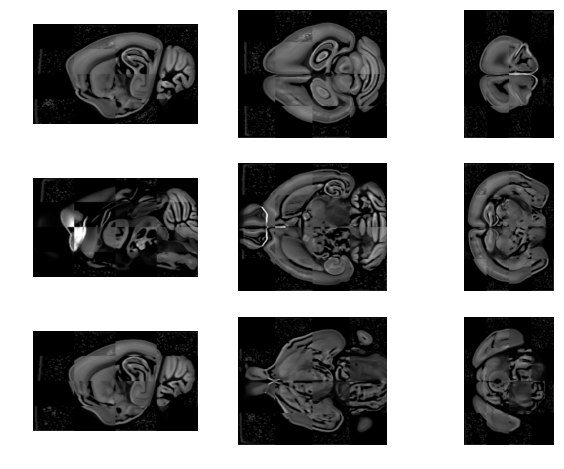

On atlas: 3/5
On mask: 2/5


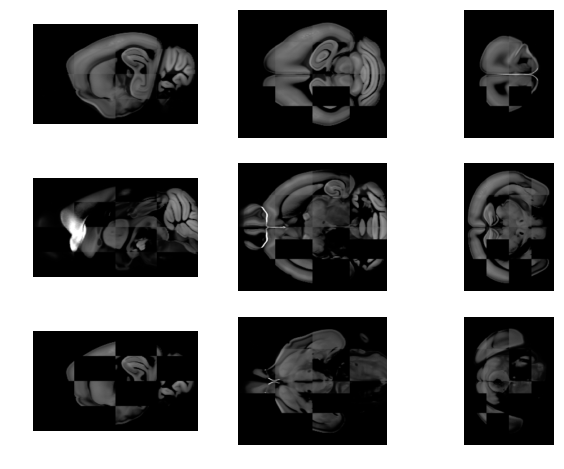

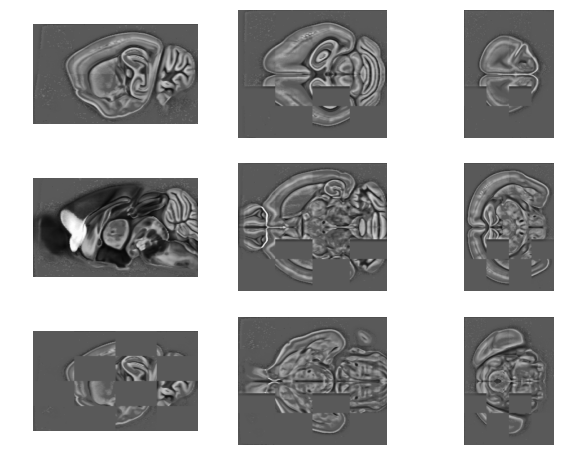


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	24632.8, 6.64388, 0, 24626.1 (93.415%), 1.100000e-03
1.	23173.5, 7.04394, 0, 23166.4 (87.8778%), 3.025000e-04
2.	20925.9, 7.64834, 0, 20918.2 (79.3497%), 1.663750e-04
3.	20538.1, 8.50009, 0, 20529.6 (77.8753%), 1.830125e-04
4.	20288.7, 9.61241, 0, 20279.1 (76.9253%), 2.013138e-04
5.	20145.9, 10.9069, 0, 20135 (76.3788%), 2.214451e-04
6.	19649.8, 11.6384, 0, 19638.1 (74.4939%), 1.217948e-04
7.	19493.6, 12.4912, 0, 19481.1 (73.8982%), 1.339743e-04
8.	19363.5, 13.4737, 0, 19350.1 (73.4011%), 1.473717e-04
9.	19220.7, 14.5943, 0, 19206.1 (72.8551%), 1.621089e-04
10.	19080.1, 15.8786, 0, 19064.2 (72.3168%), 1.783198e-04
11.	18924.5, 17.3457, 0, 18907.1 (71.721%), 1.961518e-04
12.	18778.3, 19.0286, 0, 18759.3 (71.16%), 2.157670e-04
13.	18603.2, 20.9584, 0, 18582.2 (70.4884%), 2.373436e-04
14.	18472.6, 23.1777, 0, 18449.4 (69.9846%), 2.610780e-04
15.	18285.1, 25.7273, 0, 18259.4 (69.2638%)


Step 3: alpha=0.05, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	25530.3, 0.0951483, 0, 25530.2 (99.4982%), 1.100000e-03
1.	25413.8, 0.0816551, 0, 25413.7 (99.0442%), 1.512500e-04
2.	25260.3, 0.101935, 0, 25260.2 (98.4459%), 1.663750e-04
3.	25241.6, 0.123755, 0, 25241.5 (98.373%), 1.830125e-04
4.	25176.9, 0.154685, 0, 25176.7 (98.1207%), 2.013138e-04
5.	25116.6, 0.169829, 0, 25116.4 (97.8857%), 1.107226e-04
6.	25088.2, 0.18996, 0, 25088 (97.7748%), 1.217948e-04
7.	25059.4, 0.213176, 0, 25059.2 (97.6628%), 1.339743e-04
8.	25028.4, 0.240239, 0, 25028.1 (97.5417%), 1.473717e-04
9.	24995.2, 0.27171, 0, 24994.9 (97.4123%), 1.621089e-04
10.	24959.6, 0.308419, 0, 24959.3 (97.2735%), 1.783198e-04
11.	24921.7, 0.351242, 0, 24921.3 (97.1254%), 1.961518e-04
12.	24881.2, 0.401304, 0, 24880.8 (96.9674%), 2.157670e-04
13.	24838.3, 0.45984, 0, 24837.8 (96.7999%), 2.373436e-04
14.	24792.7, 0.528441, 0, 24792.2 (96.622%), 2.610780e-04
15.	24744.9, 0.608778, 0, 2474

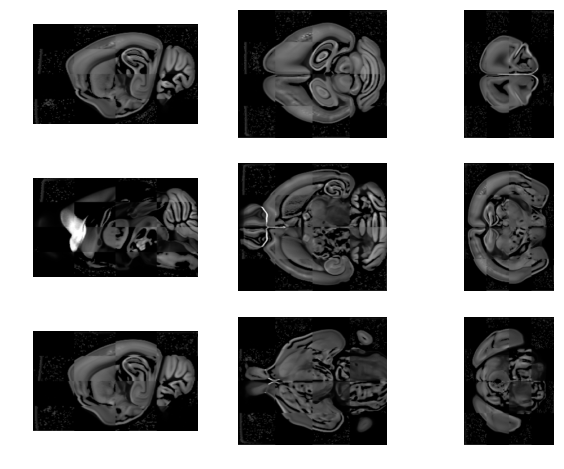

On mask: 1/2


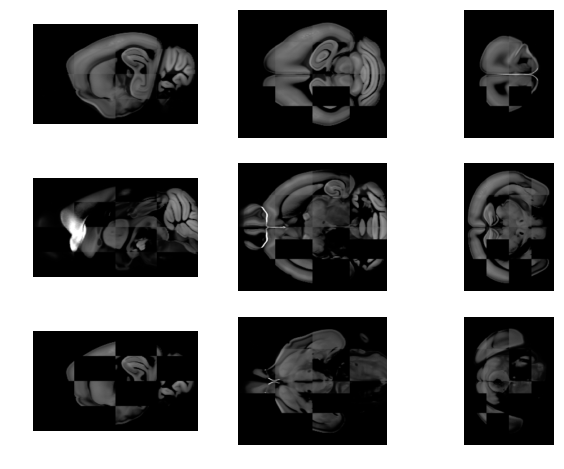

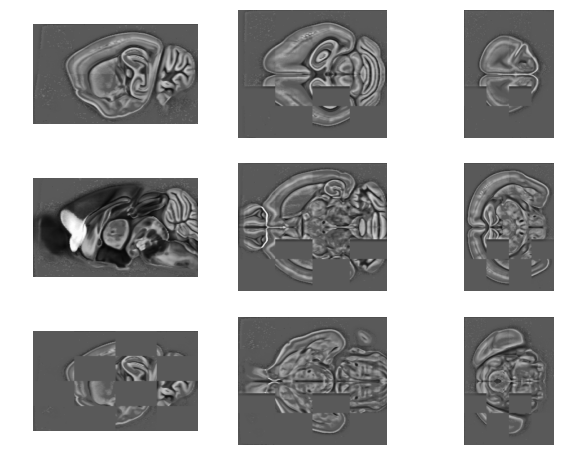


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	24632.8, 6.64388, 0, 24626.1 (93.415%), 1.100000e-03
1.	23173.5, 7.04394, 0, 23166.4 (87.8778%), 3.025000e-04
2.	20925.9, 7.64834, 0, 20918.2 (79.3497%), 1.663750e-04
3.	20538.1, 8.50009, 0, 20529.6 (77.8753%), 1.830125e-04
4.	20288.7, 9.61241, 0, 20279.1 (76.9253%), 2.013138e-04
5.	20145.9, 10.9069, 0, 20135 (76.3788%), 2.214451e-04
6.	19649.8, 11.6384, 0, 19638.1 (74.4939%), 1.217948e-04
7.	19493.6, 12.4912, 0, 19481.1 (73.8982%), 1.339743e-04
8.	19363.5, 13.4737, 0, 19350.1 (73.4011%), 1.473717e-04
9.	19220.7, 14.5943, 0, 19206.1 (72.8551%), 1.621089e-04
10.	19080.1, 15.8786, 0, 19064.2 (72.3168%), 1.783198e-04
11.	18924.5, 17.3457, 0, 18907.1 (71.721%), 1.961518e-04
12.	18778.3, 19.0286, 0, 18759.3 (71.16%), 2.157670e-04
13.	18603.2, 20.9584, 0, 18582.2 (70.4884%), 2.373436e-04
14.	18472.6, 23.1777, 0, 18449.4 (69.9846%), 2.610780e-04
15.	18285.1, 25.7273, 0, 18259.4 (69.2638%)


Step 3: alpha=0.05, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	25530.3, 0.0951483, 0, 25530.2 (99.4982%), 1.100000e-03
1.	25413.8, 0.0816551, 0, 25413.7 (99.0442%), 1.512500e-04
2.	25260.3, 0.101935, 0, 25260.2 (98.4459%), 1.663750e-04
3.	25241.6, 0.123755, 0, 25241.5 (98.373%), 1.830125e-04
4.	25176.9, 0.154685, 0, 25176.7 (98.1207%), 2.013138e-04
5.	25116.6, 0.169829, 0, 25116.4 (97.8857%), 1.107226e-04
6.	25088.2, 0.18996, 0, 25088 (97.7748%), 1.217948e-04
7.	25059.4, 0.213176, 0, 25059.2 (97.6628%), 1.339743e-04
8.	25028.4, 0.240239, 0, 25028.1 (97.5417%), 1.473717e-04
9.	24995.2, 0.27171, 0, 24994.9 (97.4123%), 1.621089e-04
10.	24959.6, 0.308419, 0, 24959.3 (97.2735%), 1.783198e-04
11.	24921.7, 0.351242, 0, 24921.3 (97.1254%), 1.961518e-04
12.	24881.2, 0.401304, 0, 24880.8 (96.9674%), 2.157670e-04
13.	24838.3, 0.45984, 0, 24837.8 (96.7999%), 2.373436e-04
14.	24792.7, 0.528441, 0, 24792.2 (96.622%), 2.610780e-04
15.	24744.9, 0.608778, 0, 2474

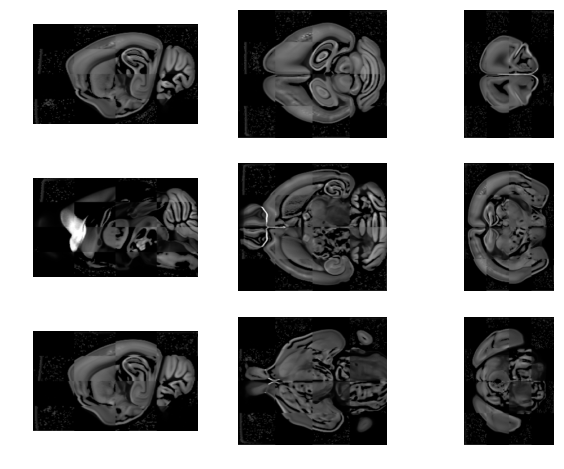

On mask: 3/5


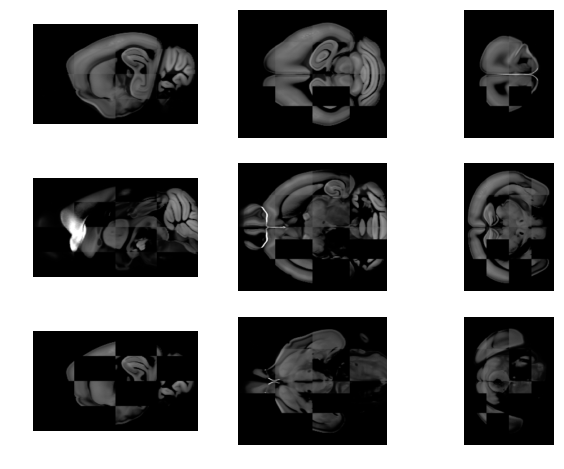

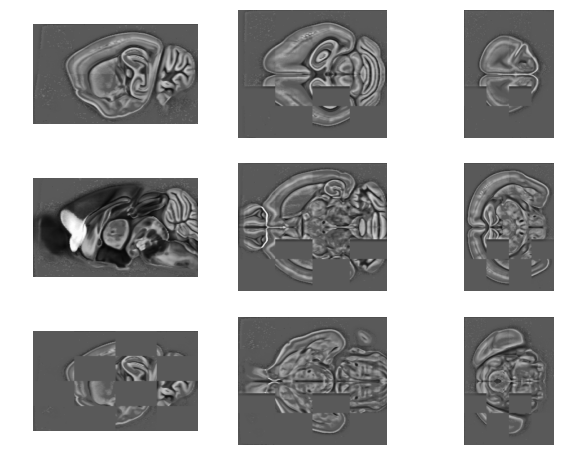


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	24632.8, 6.64388, 0, 24626.1 (93.415%), 1.100000e-03
1.	23173.5, 7.04394, 0, 23166.4 (87.8778%), 3.025000e-04
2.	20925.9, 7.64834, 0, 20918.2 (79.3497%), 1.663750e-04
3.	20538.1, 8.50009, 0, 20529.6 (77.8753%), 1.830125e-04
4.	20288.7, 9.61241, 0, 20279.1 (76.9253%), 2.013138e-04
5.	20145.9, 10.9069, 0, 20135 (76.3788%), 2.214451e-04
6.	19649.8, 11.6384, 0, 19638.1 (74.4939%), 1.217948e-04
7.	19493.6, 12.4912, 0, 19481.1 (73.8982%), 1.339743e-04
8.	19363.5, 13.4737, 0, 19350.1 (73.4011%), 1.473717e-04
9.	19220.7, 14.5943, 0, 19206.1 (72.8551%), 1.621089e-04
10.	19080.1, 15.8786, 0, 19064.2 (72.3168%), 1.783198e-04
11.	18924.5, 17.3457, 0, 18907.1 (71.721%), 1.961518e-04
12.	18778.3, 19.0286, 0, 18759.3 (71.16%), 2.157670e-04
13.	18603.2, 20.9584, 0, 18582.2 (70.4884%), 2.373436e-04
14.	18472.6, 23.1777, 0, 18449.4 (69.9846%), 2.610780e-04
15.	18285.1, 25.7273, 0, 18259.4 (69.2638%)


Step 3: alpha=0.05, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	25530.3, 0.0951483, 0, 25530.2 (99.4982%), 1.100000e-03
1.	25413.8, 0.0816551, 0, 25413.7 (99.0442%), 1.512500e-04
2.	25260.3, 0.101935, 0, 25260.2 (98.4459%), 1.663750e-04
3.	25241.6, 0.123755, 0, 25241.5 (98.373%), 1.830125e-04
4.	25176.9, 0.154685, 0, 25176.7 (98.1207%), 2.013138e-04
5.	25116.6, 0.169829, 0, 25116.4 (97.8857%), 1.107226e-04
6.	25088.2, 0.18996, 0, 25088 (97.7748%), 1.217948e-04
7.	25059.4, 0.213176, 0, 25059.2 (97.6628%), 1.339743e-04
8.	25028.4, 0.240239, 0, 25028.1 (97.5417%), 1.473717e-04
9.	24995.2, 0.27171, 0, 24994.9 (97.4123%), 1.621089e-04
10.	24959.6, 0.308419, 0, 24959.3 (97.2735%), 1.783198e-04
11.	24921.7, 0.351242, 0, 24921.3 (97.1254%), 1.961518e-04
12.	24881.2, 0.401304, 0, 24880.8 (96.9674%), 2.157670e-04
13.	24838.3, 0.45984, 0, 24837.8 (96.7999%), 2.373436e-04
14.	24792.7, 0.528441, 0, 24792.2 (96.622%), 2.610780e-04
15.	24744.9, 0.608778, 0, 2474

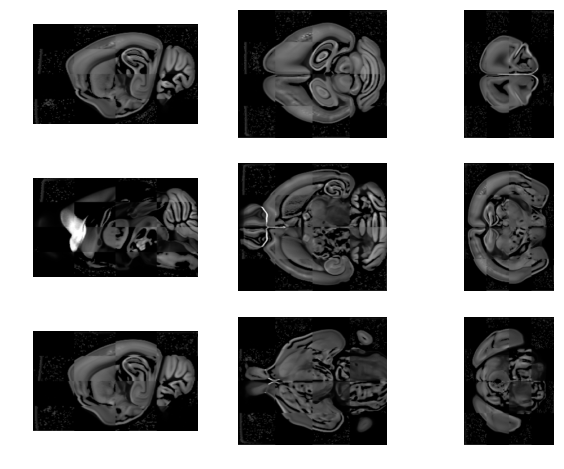

In [31]:
AFFINE_RESULTS = {}
atlas_kernel = [5,5,5]
atlas_norm = sitk.Normalize(atlas)
enums = ['2/5', '1/2', '3/5']
file_enums = ['two_fifth', 'half', 'three_fifth']
for i,img in enumerate([two_fifth_atlas, half_atlas, three_fifth_atlas]):
    print("On atlas: {}".format(enums[i]))
    for j,mask in enumerate([two_fifth_mask, half_mask, three_fifth_mask]):
        print('On mask: {}'.format(enums[j]))
        # Normalize
        assert atlas.GetSpacing() == img.GetSpacing()
        img_norm = sitk.Normalize(img)
        ndreg.imgShow(ndreg.imgChecker(atlas_norm, img_norm))
        
        # Whiten
        atlas_whitened = preprocessor.whiten(atlas_norm, radius=atlas_kernel)
        img_whitened = preprocessor.whiten(img_norm, radius=atlas_kernel)
        ndreg.imgShow(ndreg.imgChecker(atlas_whitened, img_whitened))
        assert atlas_whitened.GetSpacing() == img_whitened.GetSpacing()
        
        # LDDMM
        atlas_lddmm, field, inv_field = register_lddmm(affine_img=sitk.Normalize(atlas_whitened), 
                                                          target_img=sitk.Normalize(img_whitened),
                                                          refMask=mask,
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=1e-3, sigma=0.1,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)
        

        ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(atlas_lddmm), sitk.Normalize(atlas)))
        
        # Ingest into BOSS
        sitk.WriteImage(sitk.Normalize(atlas_lddmm), './multiscale_atlas_reg/registered_results_{}_{}.img'.format(file_enums[i], file_enums[j]))
        
        assert np.zeros((1,1)).dtype == np.float64
        AFFINE_RESULTS[(enums[i], enums[j])] = (atlas_lddmm, field, inv_field)

In [ ]:
for i in range(3):
    for j in range(3)
        print('./multiscale_atlas_reg/registered_results_{}_{}.img'.format(file_enums[i], file_enums[j]))
        print('{}_{}'.format(enums[i], enums[j]))

In [74]:
sitk.GetArrayFromImage(field)

array([[[[-0.00098672,  0.0150197 ,  0.01556368],
         [-0.00131253,  0.01507424,  0.01544977],
         [-0.0016398 ,  0.01512925,  0.01533638],
         ...,
         [ 0.00573946,  0.0136999 ,  0.01463984],
         [ 0.00547117,  0.01379687,  0.0146646 ],
         [ 0.0044625 ,  0.00251421,  0.008719  ]],

        [[-0.00087408,  0.01432447,  0.01559315],
         [-0.00120089,  0.01438244,  0.01547861],
         [-0.00152914,  0.01444085,  0.01536457],
         ...,
         [ 0.0058506 ,  0.01298217,  0.01457861],
         [ 0.00558157,  0.01308057,  0.01461093],
         [ 0.00443741,  0.00234578,  0.00876594]],

        [[-0.00076163,  0.01362379,  0.01562682],
         [-0.00108949,  0.01368515,  0.01551162],
         [-0.00141875,  0.01374692,  0.0153969 ],
         ...,
         [ 0.00596166,  0.01225908,  0.01452166],
         [ 0.00569186,  0.0123589 ,  0.01456153],
         [ 0.00441232,  0.00217209,  0.00881685]],

        ...,

        [[-0.00190879,  0.02783066,  0

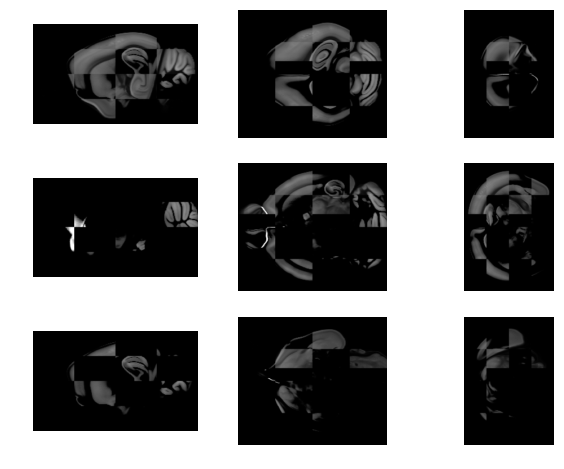

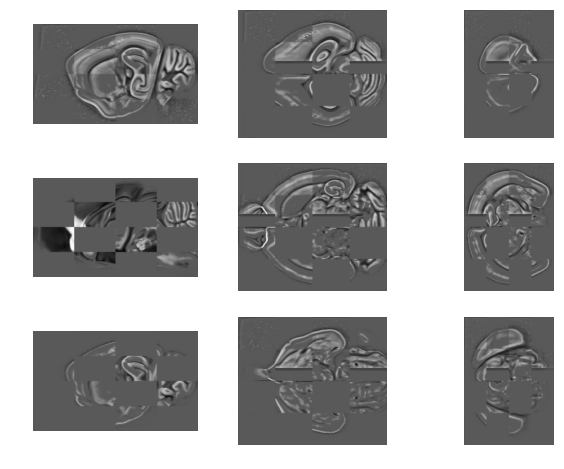

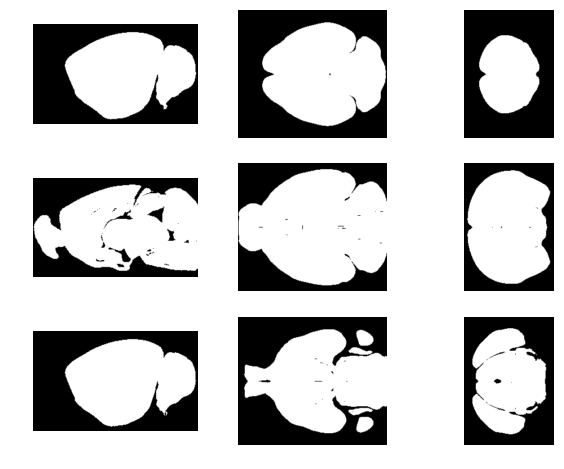


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	48248.2, 2.92846, 0, 48245.2 (89.9014%), 5.500000e-04
1.	47477.3, 4.36074, 0, 47472.9 (88.4622%), 3.025000e-04
2.	45751.7, 5.25336, 0, 45746.5 (85.2451%), 1.663750e-04
3.	44770.7, 6.49743, 0, 44764.2 (83.4148%), 1.830125e-04
4.	44311.7, 8.13507, 0, 44303.6 (82.5564%), 2.013138e-04
5.	43519.4, 10.0661, 0, 43509.3 (81.0764%), 2.214451e-04
6.	43158.3, 12.4662, 0, 43145.8 (80.3989%), 2.435896e-04
7.	42411.9, 15.2936, 0, 42396.6 (79.0029%), 2.679486e-04
8.	42057.9, 16.9292, 0, 42040.9 (78.3401%), 1.473717e-04
9.	41564.1, 18.7965, 0, 41545.3 (77.4166%), 1.621089e-04
10.	41261.7, 20.968, 0, 41240.8 (76.849%), 1.783198e-04
11.	40821.9, 23.4585, 0, 40798.4 (76.0248%), 1.961518e-04
12.	40471.2, 26.3394, 0, 40444.9 (75.3659%), 2.157670e-04
13.	39998.6, 29.6557, 0, 39969 (74.4791%), 2.373436e-04
14.	39681.8, 33.4979, 0, 39648.3 (73.8815%), 2.610780e-04
15.	39114.2, 37.9277, 0, 39076.3 (72.8157


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	49601.4, 0.111045, 0, 49601.3 (98.5174%), 1.100000e-03
1.	49579.7, 0.269044, 0, 49579.5 (98.474%), 6.050000e-04
2.	49388.3, 0.401298, 0, 49387.9 (98.0935%), 3.327500e-04
3.	49271.6, 0.416287, 0, 49271.1 (97.8616%), 1.830125e-04
4.	48829.3, 0.488586, 0, 48828.8 (96.9829%), 2.013138e-04
5.	48700.7, 0.525463, 0, 48700.1 (96.7275%), 1.107226e-04
6.	48644.9, 0.574359, 0, 48644.4 (96.6167%), 1.217948e-04
7.	48581.7, 0.630516, 0, 48581 (96.4909%), 1.339743e-04
8.	48514.7, 0.695111, 0, 48514 (96.3578%), 1.473717e-04
9.	48443.4, 0.76955, 0, 48442.7 (96.2161%), 1.621089e-04
10.	48368.1, 0.855489, 0, 48367.2 (96.0662%), 1.783198e-04
11.	48288.7, 0.954876, 0, 48287.8 (95.9084%), 1.961518e-04
12.	48205.6, 1.07001, 0, 48204.5 (95.743%), 2.157670e-04
13.	48119, 1.20361, 0, 48117.8 (95.5708%), 2.373436e-04
14.	48029.5, 1.35887, 0, 48028.1 (95.3927%), 2.610780e-04
15.	47937.7, 1.53959, 0, 47936.1 (95.

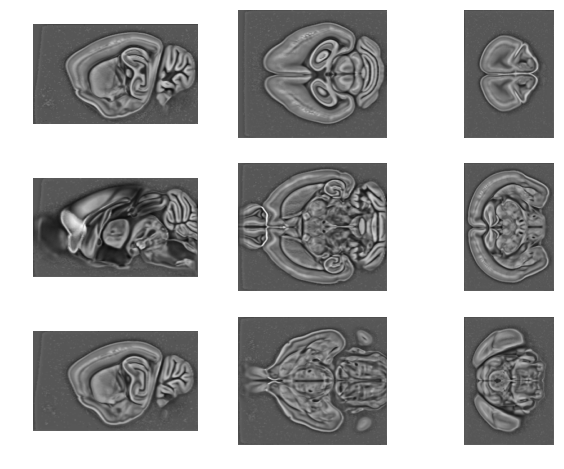

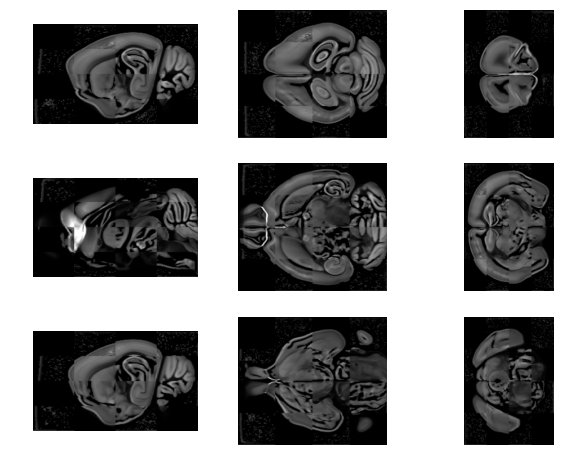

In [39]:
img_norm = sitk.Normalize(two_fifth_atlas)
ndreg.imgShow(ndreg.imgChecker(atlas_norm, img_norm))

# Whiten
atlas_whitened = preprocessor.whiten(atlas_norm, radius=atlas_kernel)
img_whitened = preprocessor.whiten(img_norm, radius=atlas_kernel)
ndreg.imgShow(ndreg.imgChecker(atlas_whitened, img_whitened))
assert atlas_whitened.GetSpacing() == img_whitened.GetSpacing()

# LDDMM
ndreg.imgShow(atlas_mask)
atlas_lddmm, field, inv_field = register_lddmm(affine_img=sitk.Normalize(atlas_whitened), 
                                                  target_img=sitk.Normalize(img_whitened),
                                                  refMask=atlas_mask,
                                                  alpha_list=[0.05], 
                                                  scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                  epsilon_list=1e-3, sigma=0.1,
                                                  min_epsilon_list=1e-10,
                                                  use_mi=False, iterations=50, verbose=True)
ndreg.imgShow(atlas_lddmm)

ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(atlas_lddmm), sitk.Normalize(atlas)))

In [69]:
import matplotlib.gridspec as gridspec


def plot_mse(img1, img2, blend=0.2, title=None, save_fig=None):
    height, width = img1.shape
    overlap = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            grey = img1[i,j]*blend + img2[i,j]*blend
            overlap[i,j] = grey
    
    x_errors = []
    for j in range(width):
        error = np.sqrt(np.sum(np.square(img1[:,j] - img2[:,j])))
        x_errors.append(error)
    x_errors = np.log(np.array(x_errors))
    
    y_errors = []
    for i in range(height):
        error = np.sqrt(np.sum(np.square(img1[i,:] - img2[i,:])))
        y_errors.append(error)
    y_errors = np.log(np.array(y_errors))
    
    gs = gridspec.GridSpec(5, 5, wspace=0.5, hspace=1)

    ax1 = plt.subplot(gs[:4, 0])
    ax2 = plt.subplot(gs[:4, 1:])
    ax3 = plt.subplot(gs[4, 1:])

    ax1.plot(y_errors, range(depth))
    ax1.invert_yaxis()
    ax1.set_xlabel('Log MSE',fontsize=12)
    ax1.set_ylabel('Row pixel', fontsize=12)

    ax3.plot(range(width), x_errors)
    ax3.set_xlabel('Column pixel',fontsize=12)
    ax3.set_ylabel('Log MSE', fontsize=12)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()

    ax2.imshow(overlap, aspect='auto')
    ax2.grid(True)
    if title:
        ax2.set_title(title, fontsize=13)
    if save_fig:
        plt.savefig(save_fig)

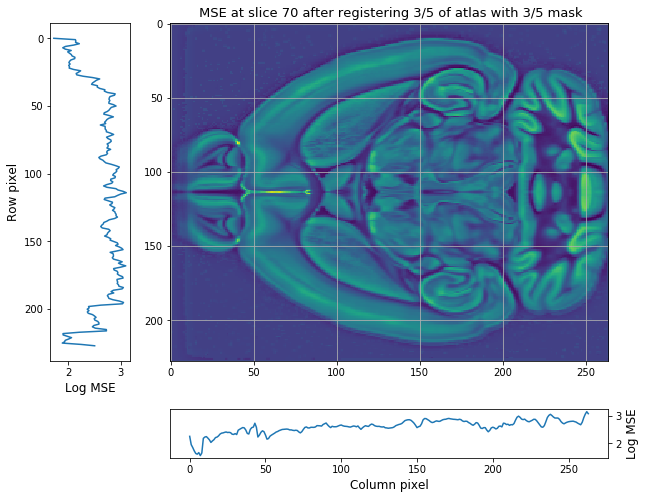

In [73]:
slice_index = 70
atlas_array = sitk.GetArrayFromImage(atlas_norm)
atlas_slice = atlas_array[:,slice_index,:]
for i,img in enumerate([two_fifth_atlas, half_atlas, three_fifth_atlas]):
    for j,mask in enumerate([two_fifth_mask, half_mask, three_fifth_mask]):
        reg_atlas, _, _ = AFFINE_RESULTS[(enums[i], enums[j])]
        reg_atlas_array = sitk.GetArrayFromImage(sitk.Normalize(reg_atlas))
        reg_atlas_slice = reg_atlas_array[:,slice_index,:]
        plot_mse(atlas_slice,
                 reg_atlas_slice, 
                 title=' MSE at slice {} after registering {} of atlas with {} mask'.format(slice_index, enums[i], enums[j]), 
                 save_fig='./multiscale_atlas_reg/slice_{}_experiment_{}_mse.png'.format(slice_index,i*3+j+1))
        

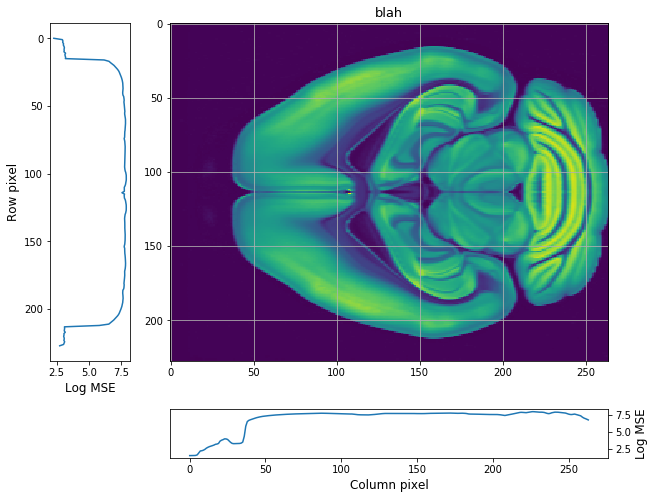

In [65]:
reg_atlas, _, _ = AFFINE_RESULTS[(enums[i], enums[j])]
reg_atlas_array = sitk.GetArrayFromImage(reg_atlas)
reg_atlas_slice = reg_atlas_array[:,50,:]
plot_mse(atlas_slice,reg_atlas_slice, title='blah', save_fig='./multiscale_atlas_reg/test.png')